# Libraries

Import your libraries
https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57

In [297]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F

In [298]:
!nvidia-smi

Wed Nov 10 13:44:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   27C    P8    18W / 250W |   5552MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

# NN = torch.load(MODEL_PATH)

# Importing Data

Import the CSV file with Actions, Sum and Div as a Dataframe called df. Fill the empty values of Action with 0. 
Replace NaN values with 0. Delete first 100 rows. 

In [299]:
#load in df
Player = 15
Game = 2

df = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_Processed_Action.csv')

#Delete first 99 rows, so df starts at timeLine == 1.00
df = df.iloc[99: , :]

df.head()

,Unnamed: 0,frAcc,frRoAcc,frDispl,frRoAng,frSpeed,timeLine,frameRotationalSpeedX,frameRotationalSpeedY,frameRotationalSpeedZ,wheelRotationalSpeedX,wheelRotationalSpeedY,wheelRotationalSpeedZ,frRoSpeed,Sum_WheelX_FrameZ,Div_FrameZ_WheelX,Filt_WheelX,Filt_FrameZ,Action
99,99,0.0,0.0,0.0,0.0,0.0,1.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN
100,100,0.0,0.0,0.0,0.0,0.0,1.01,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN
101,101,0.0,0.0,0.0,0.0,0.0,1.02,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN
102,102,0.0,0.0,0.0,0.0,0.0,1.03,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN
103,103,0.0,0.0,0.0,0.0,0.0,1.04,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN


# Pre Preprocessing

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Action', ylabel='count'>

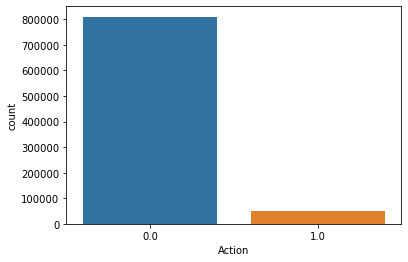

In [300]:
cols = ['wheelRotationalSpeedX','frameRotationalSpeedY','frAcc','Action']

df = df[cols]

# Fill NaN with 0
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0)

X_train.Country[X_train.Country == 0] = 'Unkown'

#Convert Sprinting to 1
df.Action.replace({'Sprinting': 1},inplace=True)

sns.countplot(df['Action'])

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Action', ylabel='count'>

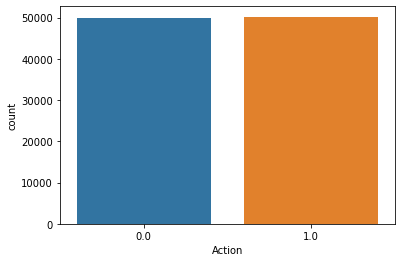

In [301]:
# Separate majority and minority classes
df_majority = df[df.Action==0]
df_minority = df[df.Action==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=50000,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df = pd.concat([df_majority_downsampled, df_minority])
 
sns.countplot(df['Action'])

In [302]:
X = df[['wheelRotationalSpeedX','frameRotationalSpeedY','frAcc']]
y = df[['Action']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Convert the X_train, X_test, y_train, y_test to Tensors

In [303]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
X_train = torch.reshape(X_train,(1,3,len(X_train)))
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
X_test = torch.reshape(X_test,(1,3,len(X_test)))
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train

torch.Size([1, 3, 80152]) torch.Size([80152])
torch.Size([1, 3, 20039]) torch.Size([20039])


tensor([[[ 2.7503e+02,  2.8000e+00, -2.1156e-01,  ...,  9.1000e-01,
           7.5234e-02, -7.7504e+01],
         [ 8.6567e+00, -1.2264e+00,  4.6667e-01,  ...,  5.1476e-01,
           2.7339e+02, -5.2850e+00],
         [-1.6739e+00,  1.0500e+00,  9.7222e-01,  ..., -2.0178e+02,
          -6.8180e+00,  2.8596e+00]]])

# CNN def
Define the Convolutional Neural Network

In [304]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(3, 18, kernel_size=10) #9 input channels, 18 output channels
        self.conv2 = nn.Conv1d(18, 36, kernel_size=10) #18 input channels from previous Conv. layer, 36 out
        self.conv2_drop = nn.Dropout2d() #dropout
        self.fc1 = nn.Linear(1044, 72) #Fully-connected classifier layer
        self.fc2 = nn.Linear(72, 19) #Fully-connected classifier layer
        self.fc3 = nn.Linear(19,1) #Fully-connected classifier layer
    
    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2_drop(self.conv2(x)),2))

        #point A
        x = x.view(x.size(0), -1)
        
        #point B
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(self.fc3(x))
    
CNN = model()

# Training options

In [305]:
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.001)

# Training the NN on the GPU


In [306]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
CNN = CNN.to(device)
criterion = criterion.to(device)

# Define functions for calculating Accuracy of model

In [307]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

# For loop through different epochs

In [308]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_test'])
    
for epoch in range(1500):
        y_pred = CNN(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
    
        if epoch % 50 == 0:
        
            train_acc = calculate_accuracy(y_train, y_pred)
        
            y_test_pred = CNN(X_test)
        
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred, y_test)
        
            test_acc = calculate_accuracy(y_test, y_test_pred)
        
            result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_test': round_tensor(test_acc)}

            Results = Results.append(result, ignore_index=True)

        #print(
#f'''epoch {epoch}
#Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
#Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
#''')
        optimizer.zero_grad()
    
        train_loss.backward()
    
        optimizer.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x721116 and 1044x72)

In [ ]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_test,'b')
plt.show()

# Validate/Tune Model

Validate results of the model (Precision/Recall). Tune the parameters of the model to achieve better results

In [ ]:
classes = ['Not Sprinting', 'Sprinting']
y_pred = CNN(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# Saving Model

MODEL_PATH = 'model.pth'

torch.save(NN, MODEL_PATH)

# Restoring Model

NN = torch.load(MODEL_PATH)